# Домашнее задание

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import math
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from torchvision import transforms, datasets

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data = fetch_california_housing(as_frame=True)

In [4]:
df = pd.DataFrame()
number_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

for col in number_features:
    df[col] = data.frame[col].fillna(0)

In [5]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [6]:
target = 'MedHouseVal'
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target].values, 
                                                    random_state=13, 
                                                    test_size=0.25)

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, lebel):
        self.df = df
        self.lebel = lebel

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
       return torch.tensor(self.df.iloc[index], dtype=torch.float32), \
              torch.tensor([self.lebel[index]], dtype=torch.float32)

In [8]:
train = MyDataset(X_train, y_train)
test = MyDataset(X_test, y_test)

In [9]:
len(train), len(test)

(15480, 5160)

In [10]:
train_loader =  torch.utils.data.DataLoader(dataset=train,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=0)
test_loader =  torch.utils.data.DataLoader(dataset=test,
                                           batch_size=8, 
                                           shuffle=True,
                                           num_workers=0)

In [11]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            LeakyReLU = nn.LeakyReLU(0.01)
            return LeakyReLU(x)
        if self.activation=="sigmoid":
            Sigmoid = nn.Sigmoid()
            return Sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 10 * hidden_dim)
        self.bn2 = nn.BatchNorm1d(10 * hidden_dim)
        self.fc2 = Perceptron(10 * hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dp = nn.Dropout(0.25)
        self.fc3 = Perceptron(hidden_dim, output_dim, "sigmoid")
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.bn3(x)
        x = self.dp(x)
        x = self.fc3(x)
        return x

In [12]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [13]:
def tain(train_loader, model, criterion, optimizer, device, epochs=5, n = 200):
    array_loss = []
    model.train()
    
    for epoch in tqdm(range(epochs)):  
        running_loss = 0.0
        array_loss_batches = []
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обнуляем градиент
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()

            # печатаем каждые n mini-batches
            if i % n == 0:
                array_loss_batches.append(running_loss / (i+1))    
                
        array_loss.extend(array_loss_batches)
    
    return array_loss

In [14]:
criterion = RMSLELoss()

model_Adam = FeedForward(8, 10, 1)
model_Adam.to(device)
optimizer_Adam = optim.Adam(model_Adam.parameters(), lr=0.001)
array_loss_Adam = tain(train_loader, model_Adam, criterion, optimizer_Adam, device)

model_SGD = FeedForward(8, 10, 1)
model_SGD.to(device)
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=0.1, momentum=0.9)
array_loss_SGD = tain(train_loader, model_SGD, criterion, optimizer_SGD, device)

model_RMSprop = FeedForward(8, 10, 1)
model_RMSprop.to(device)
optimizer_RMSprop = torch.optim.RMSprop(model_RMSprop.parameters(), lr=0.01, momentum=0.9)
array_loss_RMSprop = tain(train_loader, model_RMSprop, criterion, optimizer_RMSprop, device)

100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


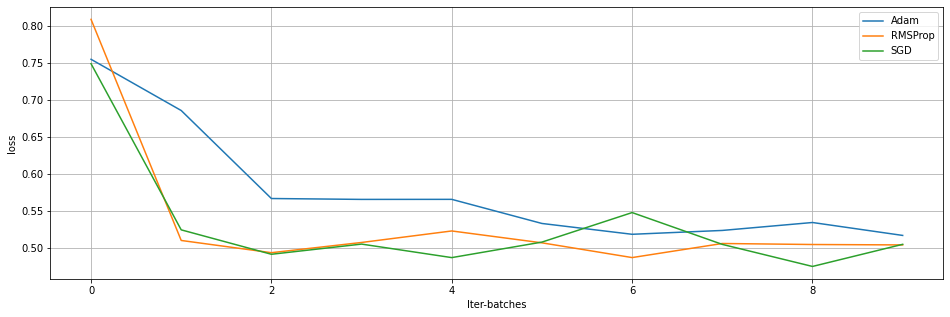

In [15]:
import matplotlib.pyplot as plt
# черчение диаграммы точности в зависимости от оптимизатора
plt.figure(figsize = (16,5))
plt.plot(array_loss_Adam, label = 'Adam')
plt.plot(array_loss_RMSprop, label = 'RMSProp')
plt.plot(array_loss_SGD, label = 'SGD')
plt.xlabel('Iter-batches')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()